In [1]:
# !pip install statsmodels

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

## ACF

* Generate and plot white noise data

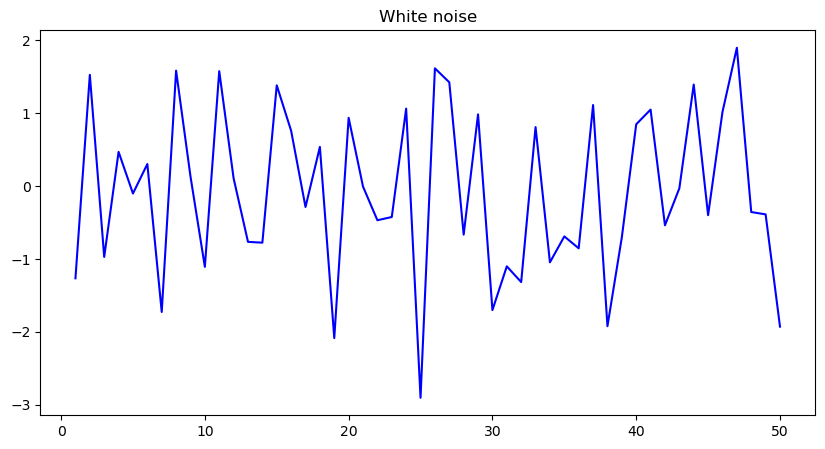

In [3]:
np.random.seed(30)

# Criando uma série de tempo com ruído branco
n = 50
index = np.arange(1, n + 1)
wn = np.random.normal(size=n)
y = pd.Series(wn, index=index, name='sample')

# Plotando a série temporal
plt.figure(figsize=(10, 5))
plt.plot(y, color='b',  linestyle='-')
plt.title('White noise')
plt.ylabel('')
plt.show()

* Plot the white noise ACF

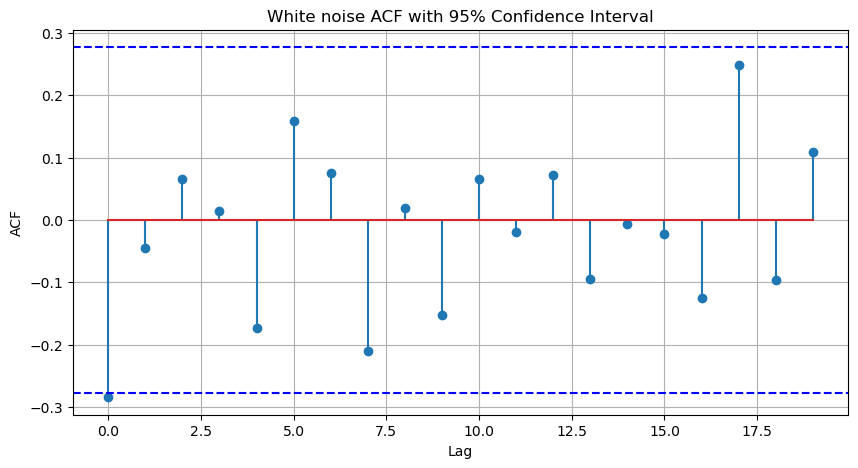

In [4]:
# Calculando a função de autocorrelação (ACF)
acf = sm.tsa.acf(wn, nlags=20)

# Calculando o valor crítico (z) para o intervalo de confiança de 95%
alpha = 0.05
z = 1.96  # z para alfa/2 = 0.025 (valor crítico de 1 - alfa/2)

# Calculando os limites do intervalo de confiança
lower_confint = -z / np.sqrt(n)
upper_confint = z / np.sqrt(n)

# Remover o primeiro valor da lista
acf = acf[1:]

# Plotando a função de autocorrelação (ACF) com o intervalo de confiança
plt.figure(figsize=(10, 5))
plt.stem(range(20), acf)
plt.axhline(y=lower_confint, color='blue', linestyle='--')
plt.axhline(y=upper_confint, color='blue', linestyle='--')
plt.title('White noise ACF with 95% Confidence Interval')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid()
plt.show()

## Simple forecasting methods to use as baseline

* Prepare the dataset: Bricks produced in Australia

In [5]:
aus_production = pd.read_csv('data/aus_production.csv')

aus_production.head()

,id,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
0,1,1956 Q1,284,5225.0,189.0,465,3923,5
1,2,1956 Q2,213,5178.0,204.0,532,4436,6
2,3,1956 Q3,227,5297.0,208.0,561,4806,7
3,4,1956 Q4,308,5681.0,197.0,570,4418,6
4,5,1957 Q1,262,5577.0,187.0,529,4339,5


In [6]:
aus_production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           218 non-null    int64  
 1   Quarter      218 non-null    object 
 2   Beer         218 non-null    int64  
 3   Tobacco      194 non-null    float64
 4   Bricks       198 non-null    float64
 5   Cement       218 non-null    int64  
 6   Electricity  218 non-null    int64  
 7   Gas          218 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 13.8+ KB


In [7]:
# Extract year and quarter and create a Period
aus_production[['Year', 'Quarter']] = aus_production['Quarter'].str.extract(r'(\d{4}) Q(\d)')
aus_production['Quarter'] = pd.to_datetime(aus_production['Year'] + 'Q' + aus_production['Quarter']).dt.to_period('Q')

# Drop the 'Year' column if you don't need it
aus_production = aus_production.drop(columns=['Year'])

# Print the updated DataFrame
print(aus_production)

      id Quarter  Beer  Tobacco  Bricks  Cement  Electricity  Gas
0      1  1956Q1   284   5225.0   189.0     465         3923    5
1      2  1956Q2   213   5178.0   204.0     532         4436    6
2      3  1956Q3   227   5297.0   208.0     561         4806    7
3      4  1956Q4   308   5681.0   197.0     570         4418    6
4      5  1957Q1   262   5577.0   187.0     529         4339    5
..   ...     ...   ...      ...     ...     ...          ...  ...
213  214  2009Q2   398      NaN     NaN    2160        57471  238
214  215  2009Q3   419      NaN     NaN    2325        58394  252
215  216  2009Q4   488      NaN     NaN    2273        57336  210
216  217  2010Q1   414      NaN     NaN    1904        58309  205
217  218  2010Q2   374      NaN     NaN    2401        58041  236

[218 rows x 8 columns]


In [8]:
bricks = aus_production[(aus_production['Quarter'] >= '1970Q1') & (aus_production['Quarter'] <= '2004Q4')][['Quarter','Bricks']]

In [9]:
bricks.head(200)

,Quarter,Bricks
56,1970Q1,386.0
57,1970Q2,428.0
58,1970Q3,434.0
59,1970Q4,417.0
60,1971Q1,385.0
...,...,...
191,2003Q4,413.0
192,2004Q1,409.0
193,2004Q2,423.0
194,2004Q3,428.0


* Create plot function

### Mean method

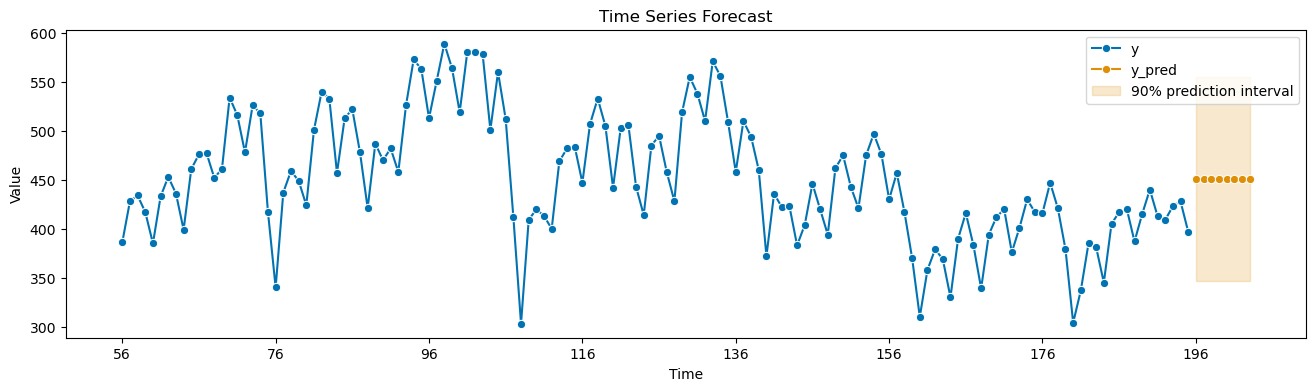

In [13]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
# import forescaster
from sktime.forecasting.model_evaluation import evaluate

def plot_forecast(model, y, forecast_horizon=8):
    # Fit the model to the training data
    model.fit(y)

    # Make forecasts
    fh = np.arange(1, forecast_horizon + 1)
    y_pred = model.predict(fh=fh)

    # Plot the actual and forecasted values
    y_pred_ints = model.predict_interval(coverage=0.9)
    plot_series(y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints)

    plt.title('Time Series Forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

# Create a Mean forecaster
model = NaiveForecaster(strategy="mean")

# Create and plot the forecast
plot_forecast(model, bricks['Bricks'])


### Naive (or random walk) method

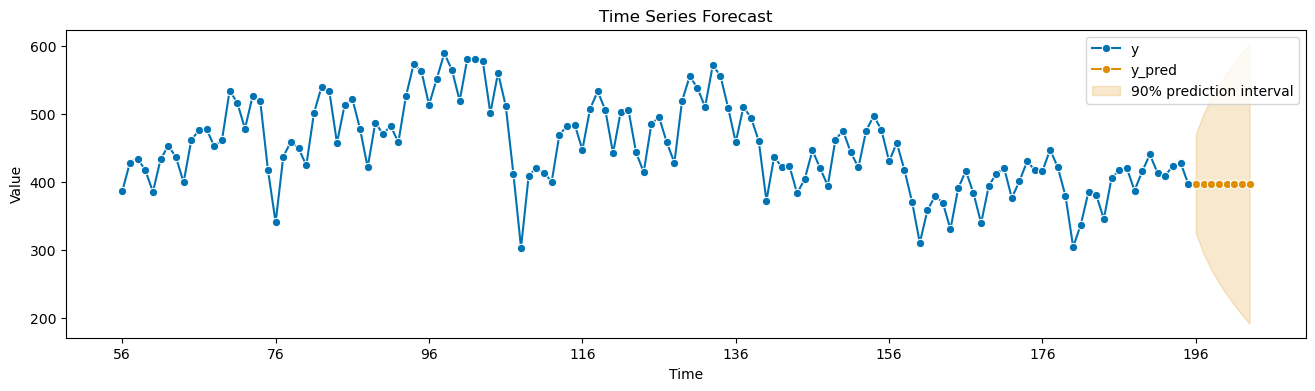

In [14]:
# Create a Naive forecaster
model = NaiveForecaster(strategy="last")

# Create and plot the forecast
plot_forecast(model, bricks['Bricks'])

### Seasonal naive method

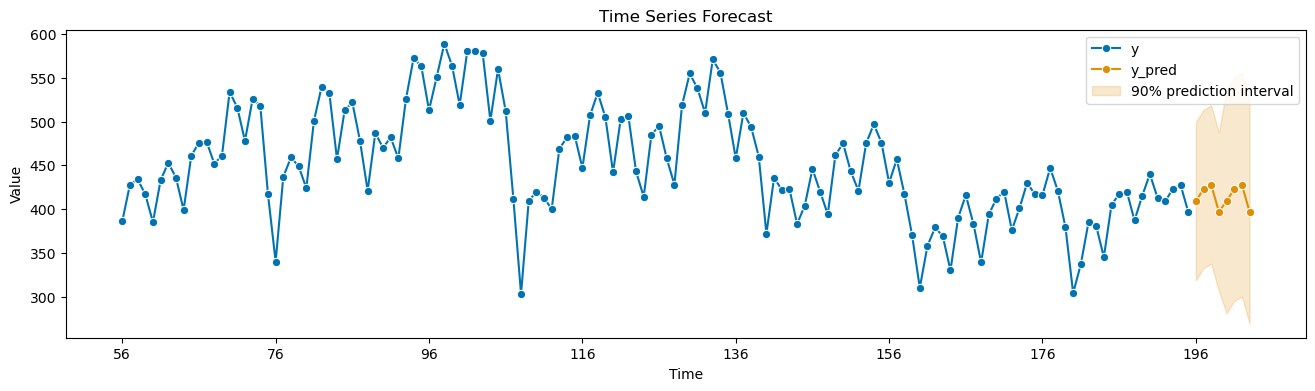

In [15]:
# Create a Seasonal Naive forecaster
model = NaiveForecaster(strategy="last", sp=4)

# Create and plot the forecast
plot_forecast(model, bricks['Bricks'])

### Drift method

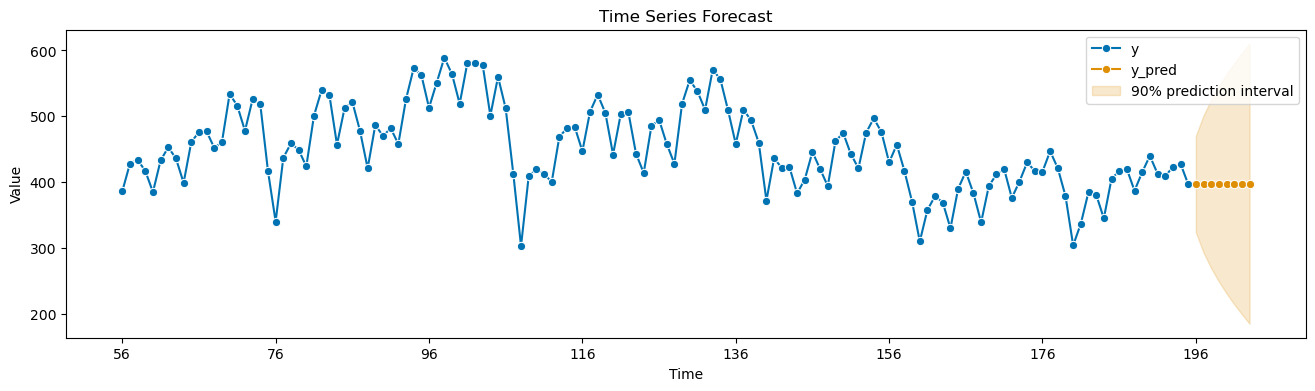

In [16]:
# Create a Drift forecaster
model = NaiveForecaster(strategy="drift")

# Create and plot the forecast
plot_forecast(model, bricks['Bricks'])

In [40]:
def plot_forecast_complex(model, y, forecast_horizon=8):
    # Fit the model to the training data
    model.fit(y)

    # Make forecasts
    fh = np.arange(1, forecast_horizon + 1)
    y_pred = model.predict(fh=fh)

    # Plot the actual and forecasted values
    y_pred_ints = model.predict_interval(coverage=0.9)
    fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints)

    plt.title('Time Series Forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    return fig, ax

<AxesSubplot:title={'center':'Time Series Forecast'}, xlabel='Time', ylabel='Bricks'>

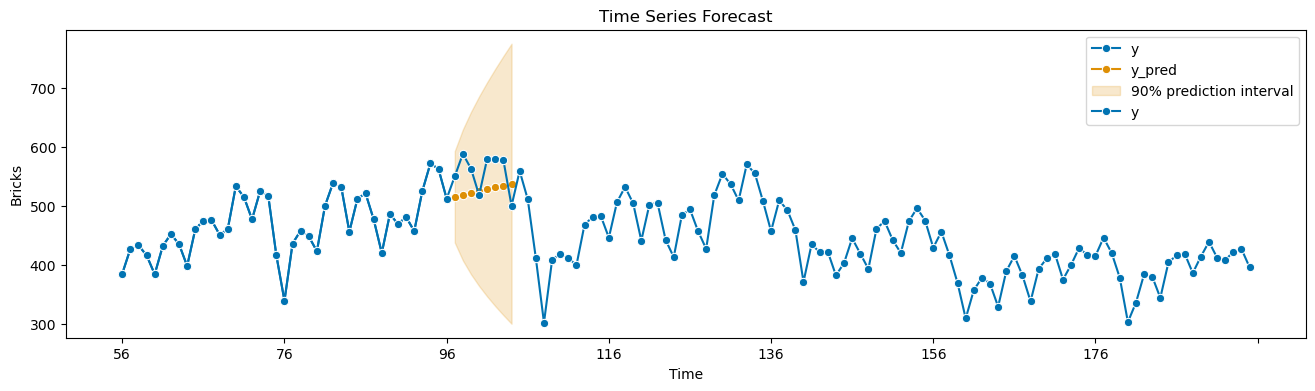

In [45]:
# Let's try a different time period - 1970 Q1 to 1980 Q1
filter = (bricks['Quarter'] >= '1970Q1') & (bricks['Quarter'] <= '1980Q1')

model = NaiveForecaster(strategy="drift")

# Create and plot the forecast
fig, ax = plot_forecast_complex(model, bricks[filter]['Bricks'])

# Plot the whole series superimposed
plot_series(bricks['Bricks'], ax=ax, labels=["y"])

### Example: Australian quarterly beer production

In [18]:
# Set training data from 1992 to 2006
train = aus_production[(aus_production['Quarter'] >= '1992Q1') & (aus_production['Quarter'] <= '2006Q4')][['Quarter','Beer']]
head = train.head(6)
tail = train.tail(6)
concat = pd.concat([head, tail])
concat


,Quarter,Beer
144,1992Q1,443
145,1992Q2,410
146,1992Q3,420
147,1992Q4,532
148,1993Q1,433
149,1993Q2,421
198,2005Q3,408
199,2005Q4,482
200,2006Q1,438
201,2006Q2,386


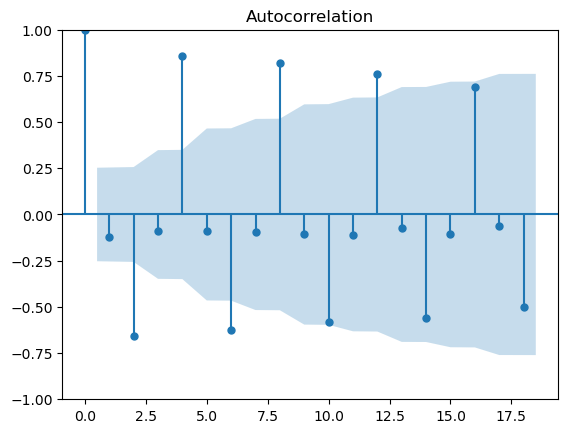

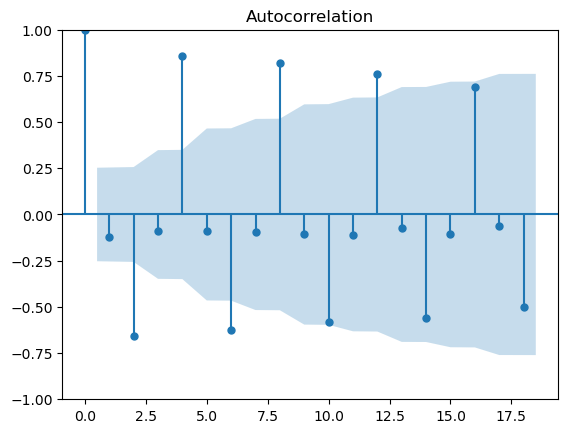

In [19]:
plot_acf(train['Beer'])

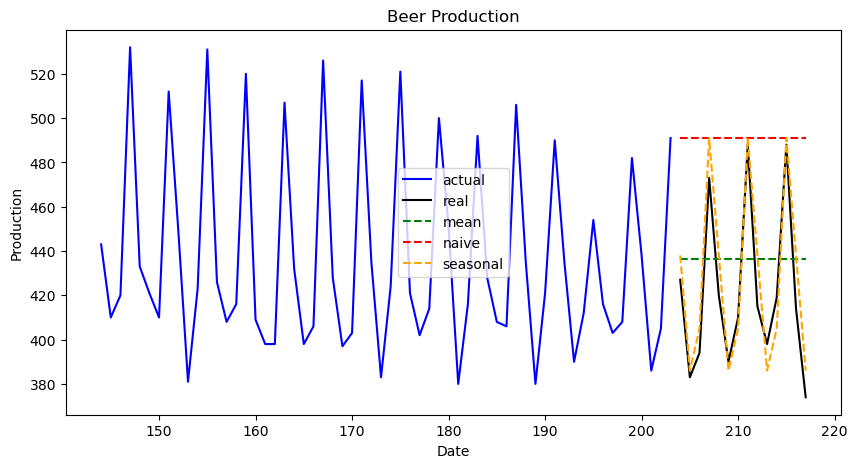

In [20]:

# Fit the models
beer_mean = NaiveForecaster(strategy="mean")
beer_mean.fit(train['Beer'])

beer_naive = NaiveForecaster(strategy="last")
beer_naive.fit(train['Beer'])

beer_seasonal = NaiveForecaster(strategy="last", sp=4)
beer_seasonal.fit(train['Beer'])

# Generate forecasts for 14 quarters
fh = np.arange(1, 15)
y_pred_mean = beer_mean.predict(fh)
y_pred_naive = beer_naive.predict(fh)
y_pred_seasonal = beer_seasonal.predict(fh)

# Plot the forecasts
plt.figure(figsize=(10, 5))
plt.plot(train['Beer'], color='blue', label='actual')
# plot real values as well
plt.plot(aus_production[(aus_production['Quarter'] >= '2007Q1')]['Beer'], color='black', label='real')
plt.plot(y_pred_mean, color='green', linestyle='--', label='mean')
plt.plot(y_pred_naive, color='red', linestyle='--', label='naive')
plt.plot(y_pred_seasonal, color='orange', linestyle='--', label='seasonal')
plt.legend()
plt.title('Beer Production')
plt.ylabel('Production')
plt.xlabel('Date')
plt.show()



### Example: Google’s daily closing stock price

In [21]:
gafa_stock = pd.read_csv('data/gafa_stock.csv')

* Use a regular time index instead of an irregular one

In [22]:

# Re-index based on trading days
google_stock = gafa_stock[gafa_stock['Symbol'] == 'GOOG']
google_stock['Date'] = pd.to_datetime(google_stock['Date'])
google_stock = google_stock[google_stock['Date'] >= '2015']
google_stock['day'] = google_stock.index
google_stock = google_stock.set_index('day')
google_stock.head()


/tmp/ipykernel_630/889934541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_stock['Date'] = pd.to_datetime(google_stock['Date'])


,Unnamed: 0,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume
day,,,,,,,,,
4026,4027,GOOG,2015-01-02,526.114746,528.362366,521.231628,521.937744,521.937744,1447600.0
4027,4028,GOOG,2015-01-05,520.396240,521.460388,510.252045,511.057617,511.057617,2059800.0
4028,4029,GOOG,2015-01-06,512.181458,513.350037,498.307800,499.212799,499.212799,2899900.0
4029,4030,GOOG,2015-01-07,504.225220,504.467896,496.915436,498.357513,498.357513,2065100.0
4030,4031,GOOG,2015-01-08,495.264526,500.724487,488.312805,499.928864,499.928864,3353600.0


* Filter and plot the variable of interest

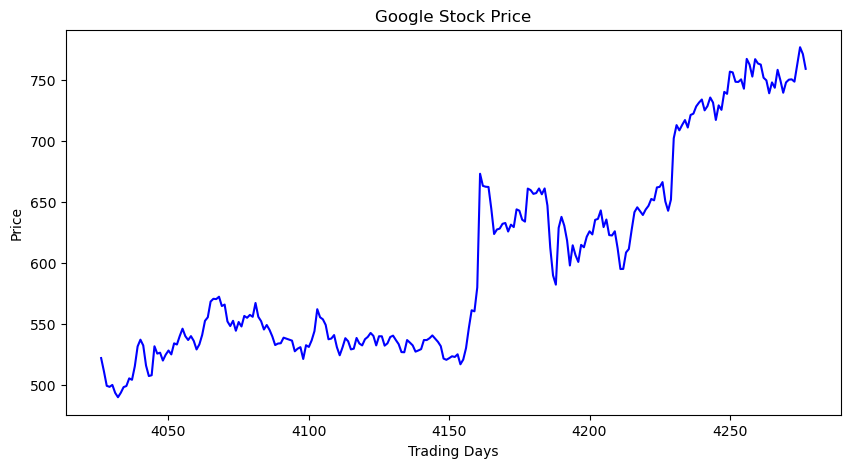

In [23]:
# Filter the year of interest
google_2015 = google_stock[google_stock['Date'].dt.year == 2015]
# Plot the closing price
plt.figure(figsize=(10, 5))
plt.plot(google_2015['Close'], color='blue')
plt.title('Google Stock Price')
plt.ylabel('Price')
plt.xlabel('Trading Days')
plt.show()

* Plot the ACF

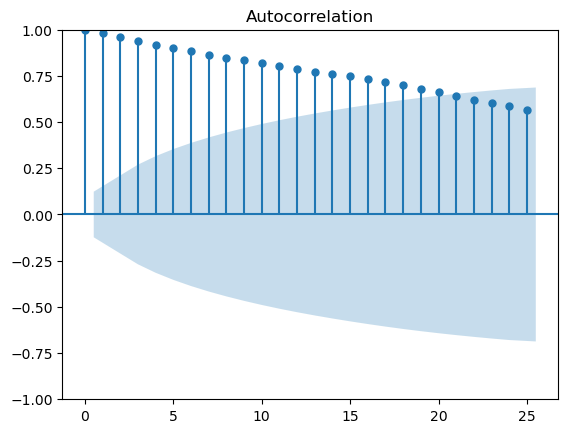

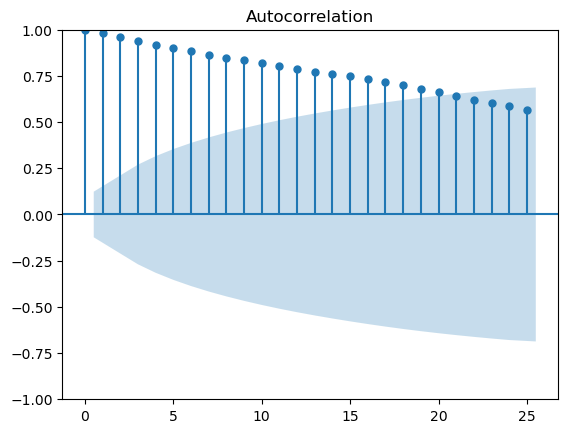

In [24]:
plot_acf(google_2015['Close'])

* Fit mean, naive and drift model to data from 2015

In [25]:
google_mean = NaiveForecaster(strategy="mean")
google_mean.fit(google_2015['Close'])

google_naive = NaiveForecaster(strategy="last")
google_naive.fit(google_2015['Close'])

google_drift = NaiveForecaster(strategy="drift")
google_drift.fit(google_2015['Close'])

NaiveForecaster(strategy='drift')

* Predict values for 2016/Jan, uses `new_data` instead of specifying periods ahead `h`.

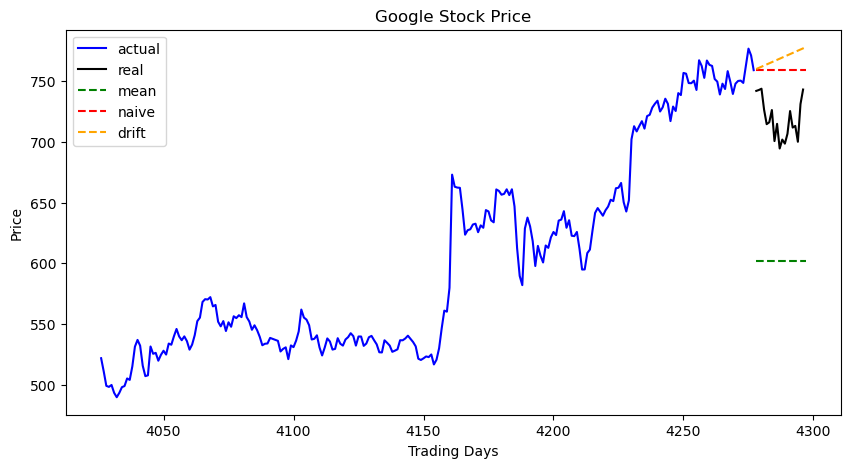

In [26]:
# Produce forecasts for the trading days in January 2016


google_jan_2016 = google_stock[google_stock['Date'].dt.year == 2016]
google_jan_2016 = google_jan_2016[google_jan_2016['Date'].dt.month == 1]

# Generate forecasts for the trading days in January 2016
fh = np.arange(1, 21)
# its 20 because we have 20 trading days in January 2016
y_pred_mean = google_mean.predict(fh)
y_pred_naive = google_naive.predict(fh)
y_pred_drift = google_drift.predict(fh)

# Plot the forecasts
plt.figure(figsize=(10, 5))
plt.plot(google_2015['Close'], color='blue', label='actual')
plt.plot(google_jan_2016['Close'], color='black', label='real')
plt.plot(y_pred_mean, color='green', linestyle='--', label='mean')
plt.plot(y_pred_naive, color='red', linestyle='--', label='naive')
plt.plot(y_pred_drift, color='orange', linestyle='--', label='drift')
plt.legend()
plt.title('Google Stock Price')
plt.ylabel('Price')
plt.xlabel('Trading Days')
plt.show()